<a href="https://colab.research.google.com/github/vvijayalakshmi21/Coursera-Machine-Learning/blob/master/fruits_vege_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

In [1]:
    !curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In this notebook we are trying to build a classifier that will be able to find out the right fruit or vegetable name is, using FastAI library. We will be making use of fruits-360 kaggle [dataset](https://www.kaggle.com/moltean/fruits
)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

We are selecting a batch size of 64


In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

The dataset features 82213 images of 120 fruits and vegetables. Our model will need to learn to differentiate between these 120 distinct categories. 

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
path = Path(base_dir + 'model_dataset')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [7]:
!pip install kaggle

In [8]:
!ls -a

.   .config  fruits-360_dataset  gdrive   models
..  data     fruits.zip		 .kaggle  stage-1.pth


In [9]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"vvijayalakshmi21","key":"2f6472c25c4ebca2f93def4a96b49b99"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [13]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [14]:
!kaggle datasets download -d moltean/fruits -p /content

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
!unzip \*.zip

Archive:  fruits.zip
replace fruits-360_dataset/fruits-360/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [16]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [17]:
%cd ..

/


In [18]:
doc(ImageDataBunch.from_folder)

In [19]:
from pathlib import Path
path = '/content/fruits-360_dataset/fruits-360'
path_obj = Path(path)
path_obj.ls()

[PosixPath('/content/fruits-360_dataset/fruits-360/test-multiple_fruits'),
 PosixPath('/content/fruits-360_dataset/fruits-360/LICENSE'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training'),
 PosixPath('/content/fruits-360_dataset/fruits-360/papers'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Test'),
 PosixPath('/content/fruits-360_dataset/fruits-360/readme.md'),
 PosixPath('/content/fruits-360_dataset/fruits-360/models')]

In [0]:
data = ImageDataBunch.from_folder(path_obj, train='Training', valid='Test', ds_tfms=get_transforms(do_flip=False), size=24)

In [21]:
print(data.classes)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Eggplant', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [22]:
print(len(data.classes))

120


In [23]:
(path_obj/'Training').ls() 

[PosixPath('/content/fruits-360_dataset/fruits-360/Training/Tomato Maroon'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Huckleberry'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Pitahaya Red'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Cherry 1'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Pepper Yellow'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Limes'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Walnut'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Rambutan'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Tomato 2'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Apple Crimson Snow'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Kiwi'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Apple Red 3'),
 PosixPath('/content/fruits-360_dataset/fruits-360/Training/Apricot'),
 PosixPath('/content/fruits-360_dataset/frui

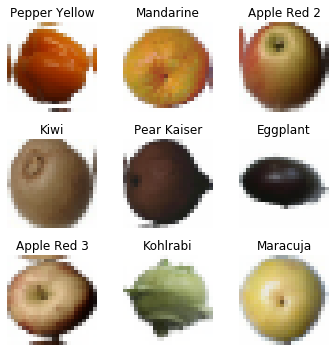

In [24]:
data.show_batch(rows=3, figsize=(5,5))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 120 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
# learn.model

In [27]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.959794,0.509329,0.146543,02:10
1,0.438353,0.217406,0.062555,02:26
2,0.249824,0.116215,0.036126,02:25
3,0.201115,0.109117,0.032296,02:23


In [0]:
learn.save('/content/stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

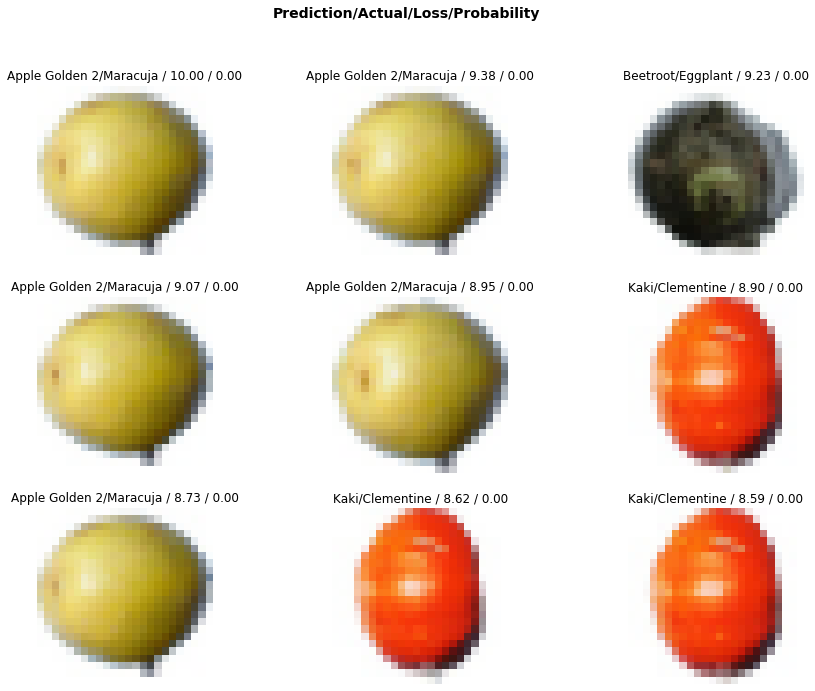

In [34]:
# interp.plot_top_losses(9, figsize=(15,11))

In [35]:
# doc(interp.plot_top_losses)

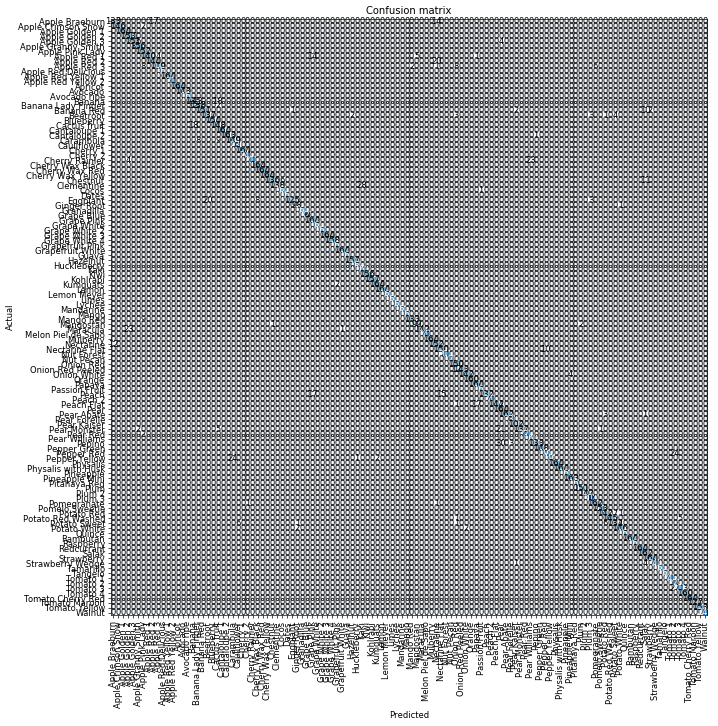

In [36]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
interp.most_confused(min_val=2)

[('Pepino', 'Pear', 30),
 ('Clementine', 'Kaki', 28),
 ('Tomato 3', 'Tomato 2', 27),
 ('Pepper Red', 'Tomato 2', 24),
 ('Pepper Yellow', 'Carambula', 24),
 ('Cherry Rainier', 'Pear Williams', 23),
 ('Maracuja', 'Apple Golden 2', 23),
 ('Pear Monster', 'Pear', 21),
 ('Apple Red 2', 'Nectarine', 20),
 ('Eggplant', 'Beetroot', 20),
 ('Banana', 'Cactus fruit', 18),
 ('Cactus fruit', 'Banana', 18),
 ('Apple Braeburn', 'Apple Red 2', 17),
 ('Peach', 'Grape Pink', 17),
 ('Peach Flat', 'Papaya', 17),
 ('Peach', 'Nectarine Flat', 15),
 ('Apple Braeburn', 'Nectarine', 14),
 ('Apple Red 1', 'Grape Pink', 14),
 ('Banana', 'Banana Lady Finger', 13),
 ('Banana Lady Finger', 'Banana', 12),
 ('Nectarine', 'Apple Braeburn', 12),
 ('Onion Red Peeled', 'Onion Red', 12),
 ('Apple Golden 2', 'Apple Golden 3', 11),
 ('Chestnut', 'Salak', 11),
 ('Banana Red', 'Salak', 10),
 ('Nectarine Flat', 'Pepper Red', 10),
 ('Carambula', 'Cactus fruit', 9),
 ('Mango Red', 'Apple Pink Lady', 9),
 ('Apple Granny Smith', '

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.054792,0.040681,0.012802,02:35


In [40]:
learn.unfreeze()
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.247586,0.178679,0.057899,02:26
1,0.049114,0.054345,0.016099,02:29
2,0.008121,0.036464,0.010183,02:39


In [48]:
learn.lr_find()
learn.lr_find()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


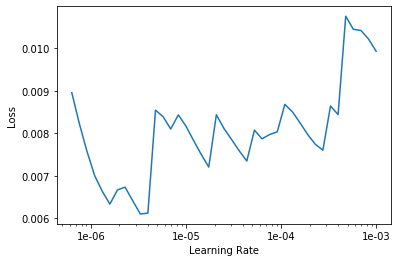

In [49]:
learn.recorder.losses
learn.recorder.plot()

That's a pretty accurate model!